In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from glob import glob

**MRI images and the corresponding Binary Masks for training the 'skull_stripping' model**

In [ ]:
def display_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')

    plt.show()

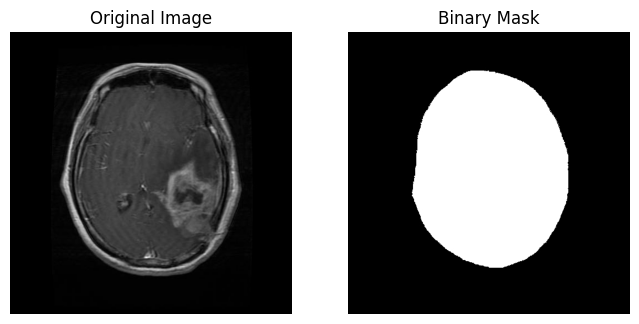

In [ ]:
axial_im = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/skull_stripping/MRI_brain_segment/axial/Te-gl_0022.jpg'
axial_mask = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/skull_stripping/MRI_brain_segment/axial_mask/Te-gl_0022.jpg'
display_image_and_mask(axial_im,axial_mask)

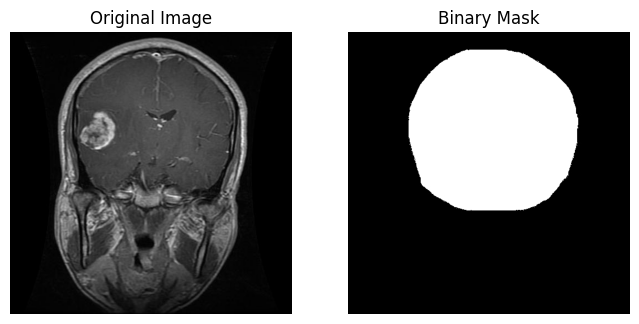

In [ ]:
coronal_im = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/skull_stripping/MRI_brain_segment/coronal/Te-gl_0036.jpg'
coronal_mask = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/skull_stripping/MRI_brain_segment/coronal_mask/Te-gl_0036.jpg'
display_image_and_mask(coronal_im,coronal_mask)

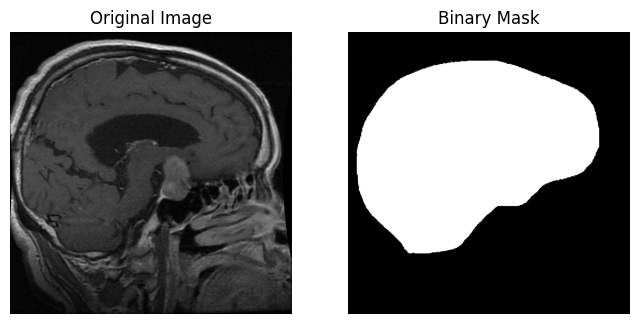

In [ ]:
sagittal_im = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/skull_stripping/MRI_brain_segment/sagittal/Te-pi_0089.jpg'
sagittal_mask = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/skull_stripping/MRI_brain_segment/sagittal_mask/Te-pi_0089.jpg'
display_image_and_mask(sagittal_im,sagittal_mask)

--------------------------------------------------------------------------------

**Training U-Net Model for skull stripping and predicting the Region of Interest (Binary Mask) to extract the Brain Region**

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/skull_stripping/MRI_brain_segment'
categories = ['axial', 'coronal', 'sagittal']

In [ ]:
def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Contracting Path
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
def load_data(img_size=(256, 256)):
    images = []
    masks = []

    for category in categories:
        img_dir = os.path.join(base_dir, category)
        mask_dir = os.path.join(base_dir, f"{category}_mask")

        img_files = glob(os.path.join(img_dir, '*.jpg'))
        mask_files = glob(os.path.join(mask_dir, '*.jpg'))

        print(f"Loading images from: {img_dir} (found {len(img_files)} files)")
        print(f"Loading masks from: {mask_dir} (found {len(mask_files)} files)")

        for img_file in img_files:
            img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            img = img / 255.0

            img_name = os.path.basename(img_file)
            mask_name = img_name

            mask_path = os.path.join(mask_dir, mask_name)
            if os.path.isfile(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, img_size)
                mask = mask / 255.0

                images.append(img)
                masks.append(mask)

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    masks = np.array(masks).reshape(-1, img_size[0], img_size[1], 1)

    return images, masks

In [ ]:
X, y = load_data()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

data_gen_args = dict(rotation_range=15,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

def train_generator(image_datagen, mask_datagen, X_train, y_train, batch_size):
    image_gen = image_datagen.flow(X_train, batch_size=batch_size, seed=45)
    mask_gen = mask_datagen.flow(y_train, batch_size=batch_size, seed=45)

    while True:
        X_batch = image_gen.__next__()
        y_batch = mask_gen.__next__()
        yield X_batch, y_batch

batch_size = 8
train_gen = train_generator(image_datagen, mask_datagen, X_train, y_train, batch_size)

Loading images from: /content/drive/MyDrive/Colab Notebooks/BTech_Project/MRI_brain_segment/axial (found 101 files)
Loading masks from: /content/drive/MyDrive/Colab Notebooks/BTech_Project/MRI_brain_segment/axial_mask (found 101 files)
Loading images from: /content/drive/MyDrive/Colab Notebooks/BTech_Project/MRI_brain_segment/coronal (found 103 files)
Loading masks from: /content/drive/MyDrive/Colab Notebooks/BTech_Project/MRI_brain_segment/coronal_mask (found 103 files)
Loading images from: /content/drive/MyDrive/Colab Notebooks/BTech_Project/MRI_brain_segment/sagittal (found 100 files)
Loading masks from: /content/drive/MyDrive/Colab Notebooks/BTech_Project/MRI_brain_segment/sagittal_mask (found 100 files)


In [ ]:
model = unet_model(input_size=(256, 256, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('skull_stripping.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=25,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

model.save('skull_stripping.keras')

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.6307 - loss: 0.6916 - val_accuracy: 0.7527 - val_loss: 0.6833
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.7458 - loss: 0.6381 - val_accuracy: 0.7773 - val_loss: 0.3882
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.8172 - loss: 0.3426 - val_accuracy: 0.8296 - val_loss: 0.3226
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.8457 - loss: 0.3011 - val_accuracy: 0.8781 - val_loss: 0.2634
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8733 - loss: 0.2605 - val_accuracy: 0.9030 - val_loss: 0.2138
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8885 - loss: 0.2156 - val_accuracy: 0.8959 - val_loss: 0.2126
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.8893 - loss: 0.2130 - val_accuracy: 0.9166 - val_loss: 0.1836
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.9067 - loss: 0.1801 - val_accuracy: 0

In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 256, 256, 32)   │            320 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_95[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 128, 128, 32)   │              0 │ conv2d_96[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_97[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 64, 64, 64)     │              0 │ conv2d_98[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 64, 64, 128)    │        147,584 │ conv2d_99[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 32, 32, 128)    │              0 │ conv2d_100[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 32, 32, 256)    │        590,080 │ conv2d_101[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 16, 16, 256)    │              0 │ conv2d_102[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)       │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_103[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_20       │ (None, 32, 32, 256)    │        524,544 │ conv2d_104[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_20       

 Total params: 23,278,565 (88.80 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,519,044 (59.20 MB)

--------------------------------------------------------------------------------

**Test the model on unseen data**

In [ ]:
model = tf.keras.models.load_model('skull_stripping.keras')

def preprocess_image(image_path, img_size=(256, 256)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = img.reshape(1, img_size[0], img_size[1], 1)
    return img

def predict_mask(image_path):
    preprocessed_image = preprocess_image(image_path)

    predicted_mask = model.predict(preprocessed_image)

    predicted_mask = np.squeeze(predicted_mask)

    threshold = 0.5
    predicted_mask = (predicted_mask > threshold).astype(np.uint8)

    return predicted_mask

def display_results(original_image_path, predicted_mask):
    original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


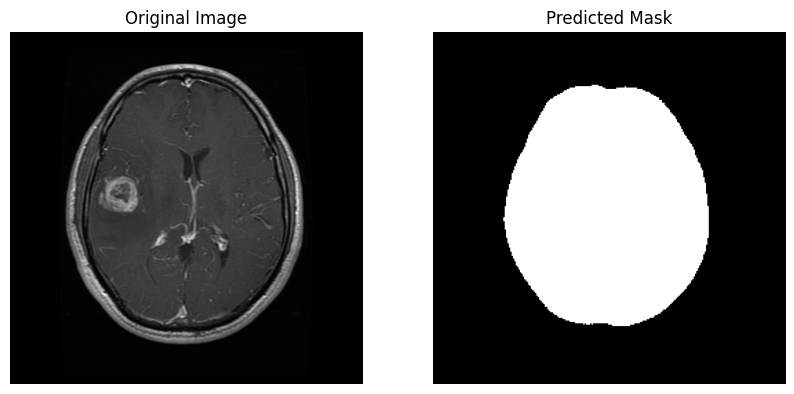

In [ ]:
test_image_path = 'a.jpg'
predicted_mask = predict_mask(test_image_path)

display_results(test_image_path, predicted_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


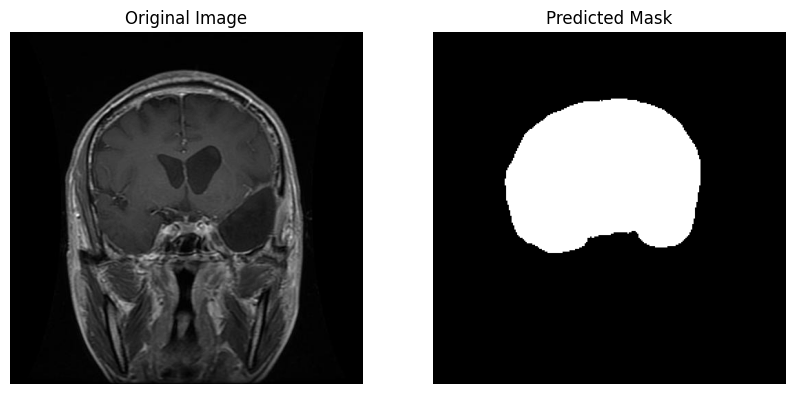

In [ ]:
test_image_path = 'c.jpg'
predicted_mask = predict_mask(test_image_path)

display_results(test_image_path, predicted_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


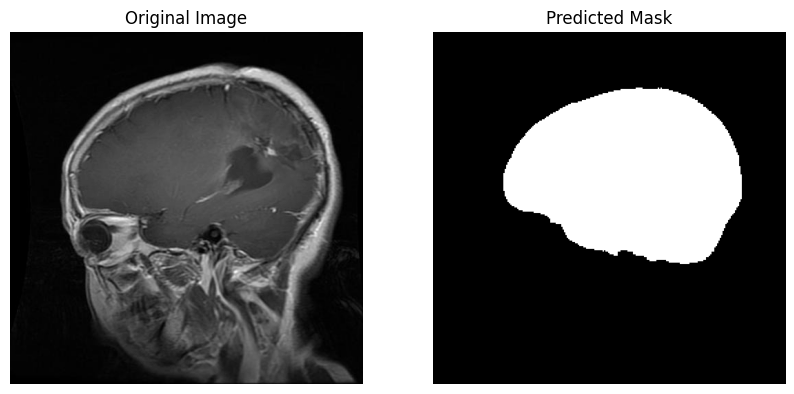

In [ ]:
test_image_path = 's.jpg'
predicted_mask = predict_mask(test_image_path)

display_results(test_image_path, predicted_mask)